In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('Mall_Customers-2.csv')
data.info()
data.drop(['CustomerID', 'Genre'], axis = 1, inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [2]:
numerical_columns = data.select_dtypes(include = ['int64', 'float64']).columns.tolist()
numerical_columns

['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [3]:
data[numerical_columns]

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

sc = StandardScaler()
data_scaled = sc.fit_transform(data)

#find epsilon value
neighbor = NearestNeighbors(n_neighbors = 5)
neighbordist = neighbor.fit(data_scaled)
distance, indices = neighbordist.kneighbors(data_scaled)
distance

array([[0.        , 0.86544824, 1.07530686, 1.15613597, 1.18113487],
       [0.        , 0.214878  , 0.21817778, 0.22058087, 0.32694123],
       [0.        , 1.07920369, 1.25922251, 1.28368768, 1.53846858],
       [0.        , 0.09008039, 0.16870371, 0.18571321, 0.214878  ],
       [0.        , 0.37867618, 0.43757688, 0.86544824, 0.86548116],
       [0.        , 0.09008039, 0.16332841, 0.18767283, 0.22058087],
       [0.        , 0.31666705, 0.83432659, 0.89872183, 1.06486558],
       [0.        , 0.50013409, 0.53704392, 0.59167443, 0.66436695],
       [0.        , 0.47824143, 0.51009801, 0.6355295 , 0.90300379],
       [0.        , 0.24311759, 0.40827832, 0.47386836, 0.523327  ],
       [0.        , 0.47824143, 0.64819063, 0.76116314, 0.99420153],
       [0.        , 0.15753602, 0.85964041, 0.88362925, 1.05089524],
       [0.        , 0.42089949, 0.59046855, 0.6355295 , 0.64819063],
       [0.        , 0.16318788, 0.16870371, 0.18767283, 0.22929187],
       [0.        , 0.31666705, 0.

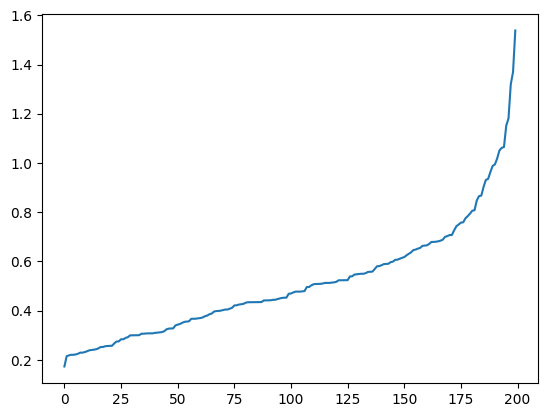

In [5]:
import matplotlib.pyplot as plt
distance = np.sort(distance, axis = 0)
plt.plot(distance[:, 4])
plt.show()

In [6]:
eps = [0.6, 0.7, 0.8, 0.9]
min_pts = [4, 5, 6] #2 * no. of dimention i.e. 2*3 = 6 to be chosen

from sklearn.cluster import DBSCAN
result = []
for e in eps:
    for n in min_pts:
        dbscan = DBSCAN(eps = e, min_samples = n)
        y_cluster = dbscan.fit_predict(data_scaled)
        n_cluster = len(set(y_cluster)) - (1 if -1 in y_cluster else 0)
        n_noise = list(y_cluster).count(-1)
        result.append((e, n, n_cluster, n_noise))

result_df = pd.DataFrame(result, columns = ['eps', 'minsamples', 'n_clusters', 'n_noise'])
result_df

,eps,minsamples,n_clusters,n_noise
0,0.6,4,3,18
1,0.6,5,2,28
2,0.6,6,5,34
3,0.7,4,2,9
4,0.7,5,1,14
5,0.7,6,1,19
6,0.8,4,1,5
7,0.8,5,1,6
8,0.8,6,1,6
9,0.9,4,1,2


In [7]:
#eps = 0.6 max number of clusters #min_samples = 2 * 3 = 6 as eps increases number of clusters decreases
db_model = DBSCAN(eps = 0.6, min_samples = 6)
y_cluster = db_model.fit_predict(data_scaled)

data['Clusters'] = y_cluster
cluster_analysis = data.groupby('Clusters').mean()
cluster_analysis

,Age,Annual Income (k$),Spending Score (1-100)
Clusters,,,
-1,38.558824,71.558824,32.735294
0,39.580952,49.038095,53.885714
1,37.600000,29.000000,28.800000
2,50.500000,29.750000,9.250000
3,32.588235,81.647059,82.558824
4,44.722222,82.777778,15.611111


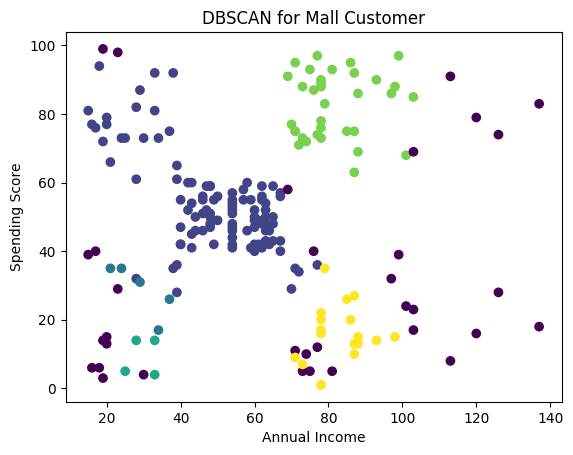

In [8]:
#with noise data points to identify outlier
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],
            c = data['Clusters'], cmap = 'viridis')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('DBSCAN for Mall Customer')
plt.show()

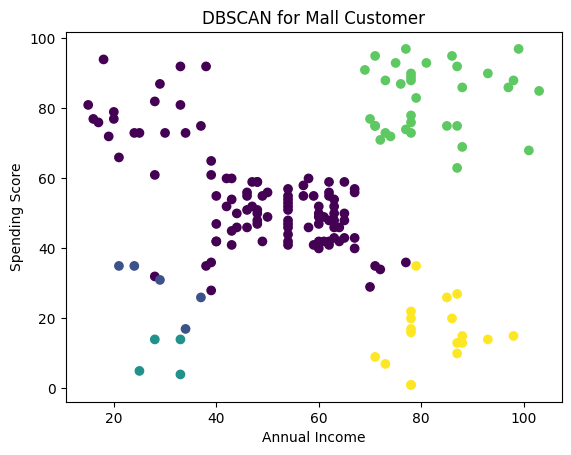

In [9]:
#without noise data points
data = data[data['Clusters']!=-1]
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],
            c = data['Clusters'], cmap = 'viridis')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('DBSCAN for Mall Customer')
plt.show()

In [10]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

ss_score = silhouette_score(data_scaled, y_cluster)
dv_score = davies_bouldin_score(data_scaled, y_cluster)
ch_score = calinski_harabasz_score(data_scaled, y_cluster)
print('Silhouette Score', ss_score)
print('Davis Bouldin', dv_score)
print('Calinski Score', ch_score)

Silhouette Score 0.0761719083916041
Davis Bouldin 2.149925045967779
Calinski Score 20.093904649541248
